# 딥러닝을 활용한 텍스트 분류 파이프라인


<img src='https://raw.githubusercontent.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs/refs/heads/main/cover.png'
     alt="NLP와 LLM 실전 가이드(한빛미디어)"
     style="border: 3px solid gray; box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.3); border-radius: 10px; width: 300px;"   width='300'>


* 저자:  
    - [Lior Gazit](https://www.linkedin.com/in/liorgazit).  
    - [Meysam Ghaffari](https://www.linkedin.com/in/meysam-ghaffari-ph-d-a2553088/).
* 역자:
    - [박조은](https://github.com/corazzon)
* 이 노트북은 다음의 책에서 소개하는 내용입니다.
    - 역서 : NLP와 LLM 실전 가이드(한빛미디어)
    - 원서 : [Mastering NLP from Foundations to LLMs](https://www.amazon.com/dp/1804619183)

colab 실습 :
https://github.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/Mastering-NLP-from-Foundations-to-LLMs/blob/main/Chapter5_notebooks/Ch5_Text_Classification_Traditional_ML.ipynb)  


원서 Colab 실습:   
https://github.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs   
<a target="_blank" href="https://colab.research.google.com/github/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/blob/liors_branch/Chapter6_notebooks/Ch6_Text_Classification_DL.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**목적 : 의학 논문의 결론을 처리하고 해당 결론이 조언을 나타내는지 여부를 추론하기**

본 노트북은 Chapter 6을 바탕으로 딥러닝 이진 분류기의 완전한 엔드-투-엔드 시스템 설계를 보여줍니다.
주어진 텍스트를 관찰하여 해당 내용이 의학적 조언인지 아닌지를 분류기가 추론합니다.

## 파이프라인 구성:

1. 코드 설정  
2. 데이터 수집  
3. 데이터 처리  
4. 전처리  
5. 초기 데이터 탐색  
6. 특성 엔지니어링  
7. 생성된 수치 특성 탐색  
8. 학습/테스트 데이터 분할  
9. 초기 통계 분석 및 가능성 평가  
10. 특성 선택  
11. 머신러닝  
  11.1 다양한 머신러닝 모델 실험  
  11.2 최적의 모델 생성  
  11.3 학습 결과 확인  
  11.4 테스트 결과 확인  
12. 딥러닝  
  12.1 데이터 포맷 준비  
  12.2 언어 모델(LM) 학습  
    12.2.1 학습 하이퍼파라미터 설정  
    12.2.2 평가 지표 선정  
    12.2.3 트레이너 객체 구성  
    12.2.4 모델 미세 조정  
    12.2.5 학습 시간 분석 및 결론  
    12.2.6 학습 결과 생성  
    12.2.7 테스트 결과 생성  


**참고:**  
이 노트북은 단일 파일로 모든 머신러닝 파이프라인 단계를 통합하여 실행할 수 있도록 설계되었습니다. 그러나 실제 개발 환경에서는 코드의 재현성과 효율성을 높이기 위해 워크플로를 여러 `.py` 파일로 분리하는 것이 바람직합니다.

## 데이터:
[Hugging Face의 데이터셋:  
medical_meadow_health_advice](https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice):  

> 이 데이터셋은 의료 논문의 결론을 담고 있는 수천 개의 텍스트 데이터를 포함하고 있습니다. 각 결론은 해당 내용이 조언인지 아닌지에 대한 주석이 달려 있습니다.

**요구사항:**  
* Colab 환경에서 실행 시 다음 런타임 설정을 사용하세요: `Python3, T4 GPU`  

>*```면책사항: 이 노트북에서 다루는 내용과 아이디어는 저자들 개인의 것이며, 저자들의 고용주의 견해나 지적 재산을 대변하지 않습니다.```*

설치:

In [ ]:
# 주의:
# 아래 코드가 Python 패키지 충돌로 인해 에러가 발생할 경우, 이는 새로운 버전이 원인일 수 있습니다.
# 이런 경우, "default_installations" 값을 False로 설정하여 원래 이미지로 되돌리세요:
default_installations = True
if default_installations:
    !pip -q install transformers==4.28.0 datasets num2words autocorrect accelerate evaluate
else:
    import requests
    text_file_path = "requirements__Ch6_Text_Classification_DL.txt"
    url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter6_notebooks/" + text_file_path
    res = requests.get(url)
    with open(text_file_path, "w") as f:
        f.write(res.text)

    !pip install -r requirements__Ch6_Text_Classification_DL.txt

Imports:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
from datasets import load_dataset, Dataset

from num2words import num2words
import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# DL imports:
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

In [ ]:
!pip install -Uq koreanize-matplotlib
import koreanize_matplotlib

### 코드 설정

In [ ]:
# config_dict:
# source_of_dataset: 데이터셋을 패키지에서 로드할지 URL에서 로드할지 결정 (이 노트북에서 사용되는 데이터셋의 경우 두 옵션 모두 가능)
# json_url: 데이터셋의 .json 파일 URL
# db_name: HuggingFace에서 원시 데이터를 보유한 데이터베이스 이름
# do_preprocessing: 논리 값, 전처리를 수행할지 여부
# do_enhanced_preprocessing: 논리 값, 고비용 전처리를 수행할지 여부
# do_feature_eng: 논리 값, 특성 공학 수행 여부
# maximize_a_priori: 논리 값, 단변량 초기 특성 선택을 사전(a priori) 통계 또는 사후(a postiori) 통계 기반으로 할지 여부
# num_chosen_features_per_class: 정수형, 초기 특성 선택 시 클래스당 선택할 특성 개수
# test_size: 0과 1 사이의 값, 테스트 데이터 비율
# feature_eng_details: "TfidfVectorizer" (TF-IDF 기반 특성 공학) 또는 "CountVectorizer" (원-핫 인코딩) 중 하나 선택
# seed: 정수형, 결과 재현성을 보장하기 위한 랜덤 시드 값
config_dict = {'source_of_dataset': "json",
               'json_url': "https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice/raw/main/medical_meadow_health_advice.json",
               'db_name': "medalpaca/medical_meadow_health_advice",
               'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': False,
               'num_chosen_features_per_class': 200,
               'test_size': 0.25,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 3,
               'max_features': 1000,
               'seed': 0}

# 딥러닝 학습 매개변수:
# transformers.TrainingArguments에 대한 문서에서 입력 매개변수 설명을 참고하세요.
lm_training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    evaluation_strategy="steps",
    logging_steps=100,
    report_to="none")

layers_to_fine_tune = None

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


### 데이터 수집

In [ ]:
# 데이터셋을 datasets 패키지를 통해 가져오거나 URL에서 직접 가져오기:
if config_dict["source_of_dataset"] == "datasets package":
    # HuggingFace의 datasets 패키지를 사용하여 데이터셋 로드
    dataset_raw = load_dataset(config_dict["db_name"])
    dataset_df = pd.DataFrame(dataset_raw["train"])
elif config_dict["source_of_dataset"] == "json":
    # json에 특정 파일 url 을 설정 했을 때:
    dataset_df = pd.read_json(config_dict["json_url"])

### 데이터 처리

In [ ]:
dataset_df["_label_"] = dataset_df["output"]
dataset_df["text"] = dataset_df["input"]
dataset_df = dataset_df[["text", "_label_"]]

데이터 미리보기:  

In [ ]:
dataset_df.head(4).style.set_properties(**{'text-align': 'left'})

In [ ]:
print("원래 레이블의 분포:\n")
dataset_df[["_label_"]].value_counts()

다중 클래스 분류 모델을 학습시켜 3개의 레이블을 모두 구분할 수도 있지만, 이를 이진 분류 문제로 단순화할 것입니다.  
조언을 나타내는 두 개의 레이블을 하나로 합쳐 텍스트가 '조언인지 아닌지'를 판별하는 이진 결정 문제로 전환합니다.  
따라서 레이블을 다음과 같이 재설정할 것입니다:

>>
레이블 0: **조언이 아님**  
레이블 1: 조언임  

이제 분류 문제는 이진 분류 문제가 됩니다.  

#### 타겟 클래스 선택하기

In [ ]:
dataset_df_binary = dataset_df.copy()
dataset_df_binary["_label_"] = dataset_df["_label_"].map({"This is no advice":0}).fillna(1).map(int)
dataset_df_binary.head()

In [ ]:
print("새로운 레이블의 분포:\n")
frequencies = dataset_df_binary[["_label_"]].value_counts()
frequencies

가장 빈도가 높은 클래스를 식별합니다.  
이는 이 데이터셋에 대한 기준 정확도(사전 확률)를 설정합니다:

In [ ]:
most_frequent_class = frequencies.index[:][0][0]
print("가장 빈도가 높은 클래스는:", most_frequent_class)
print("해당 클래스의 기준 정확도는:", round((dataset_df_binary["_label_"] == most_frequent_class).mean(), 3))

### 전처리

전처리 유틸리티 함수 정의:

In [ ]:
def digits_to_words(match):
    """
    문자열 숫자를 영어 단어로 변환합니다. 이 함수는 기수(cardinal)와 서수(ordinal)를 구분합니다.
    예: "2"는 "two"로, "2nd"는 "second"로 변환됩니다.

    입력: str
    출력: str
    """
    suffixes = ['st', 'nd', 'rd', 'th']
    # 문자열을 소문자로 변환하여 이전 작업에 의존하지 않도록 보장:
    string = match[0].lower()
    if string[-2:] in suffixes:
        type = 'ordinal'
        string = string[:-2]
    else:
        type = 'cardinal'

    return num2words(string, to=type)


def spelling_correction(text):
    """
    잘못된 철자를 올바른 철자로 교정합니다.

    입력: str
    출력: str
    """
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)


def remove_stop_words(text):
    """
    불용어(stopwords)를 제거합니다.

    입력: str
    출력: str
    """
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])


def stemming(text):
    """
    각 단어에 대해 개별적으로 어간 추출(stemming)을 수행합니다.

    입력: str
    출력: str
    """
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatizing(text):
    """
    각 단어에 대해 개별적으로 원형 복원(lemmatization)을 수행합니다.

    입력: str
    출력: str
    """
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def preprocessing(input_text):
    """
    텍스트 전처리를 위한 전체 파이프라인을 수행하는 함수입니다.

    입력: str
    출력: str
    """
    output = input_text
    # 소문자로 변환:
    output = output.lower()
    # 숫자를 단어로 변환:
    # 아래 정규 표현식은 숫자 뒤에 서수 접미사가 있을 가능성을 검색합니다:
    output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
    # 구두점 및 기타 특수 문자를 제거:
    output = re.sub('[^ A-Za-z0-9]+', '', output)

    if config_dict["do_enhanced_preprocessing"]:
        # 철자 교정:
        output = spelling_correction(output)

    # 불용어 제거:
    output = remove_stop_words(output)

    if config_dict["do_enhanced_preprocessing"]:
        # 어간 추출:
        output = stemming(output)
        # 원형 복원:
        output = lemmatizing(output)

    return output

전처리 수행:

In [ ]:
dataset_clean = dataset_df_binary.copy()
if config_dict["do_preprocessing"]:
    dataset_clean["text"] = [preprocessing(text) for text in dataset_clean["text"]]

In [ ]:
dataset_clean[["text", "_label_"]].head(10).style.set_properties(**{'text-align': 'left'})

## 초기 데이터 탐색

모든 머신러닝 프로젝트는 데이터의 기본적인 탐색으로 시작해야 합니다.  
주요 목표는 데이터의 특성을 이해하고, "X" 데이터(여기서는 입력 텍스트)와 원하는 값 "Y"(여기서는 조언으로 분류 여부) 사이에 연결고리가 있는지를 확인하는 것입니다.

여기에서는 데이터의 가장 단순한 특성인 각 입력의 길이를 살펴보는 것으로 시작합니다.  
이후에는 사용된 언어와 조언 레이블 간의 통계적 의존성을 탐구할 것입니다.

In [ ]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="_label_",
                             bins=50, alpha=0.5, figsize=(10, 6),
                             title="클래스별 문자열 길이 분포",
                             xlim=[0, 1000])

## 특성공학

In [ ]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
    # 특성 공학: CountVectorizer를 이용한 이진 인코딩 또는 Bag of Words 방식
    if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
        print("특성 공학 방식: 이진 인코딩 (원-핫 인코딩)")
        countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"],
                                                       config_dict["ngram_range_max"]),
                                          stop_words='english',
                                          max_features=config_dict["max_features"],
                                          binary=True)

    elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
        print("특성 공학 방식: Bag of Words")
        countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"],
                                                       config_dict["ngram_range_max"]),
                                          stop_words='english',
                                          max_features=config_dict["max_features"],
                                          binary=False)

    # 입력 텍스트 데이터를 CountVectorizer로 변환
    out_arr = countvectorizer.fit_transform(in_df[text_col])
    count_tokens = countvectorizer.get_feature_names_out()
    out_df = pd.DataFrame(data=out_arr.toarray(), columns=count_tokens)
    out_df[labels_col] = list(in_df[labels_col])  # 레이블 컬럼 추가
    return out_df


if config_dict["do_feature_eng"]:
    # 특성 공학 수행
    dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', '_label_', config_dict)
else:
    # 이 옵션은 지원되지 않아 노트북이 실행되지 않을 것입니다.
    # 이 옵션은 가공된 특성이 아닌 텍스트를 직접 처리하는 딥러닝 언어 모델을 사용하는 머신러닝 파이프라인을 위해 여기에 포함되어 있습니다.
    dataset_feat_eng = dataset_clean.copy()

## 생성된 수치형 특성 탐색

In [ ]:
dataset_feat_eng.head()

In [ ]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]

## Train/Test 데이터 세트 나누기

In [ ]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"],random_state=config_dict['seed']).copy()
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index).copy()
dataset_feat_eng_test.shape, dataset_feat_eng_train.shape

## 초기 통계 분석 및 타당성 조사

이 과정은 머신러닝을 적용하기 전에 수행하는 초기 연구에서 가장 가치 있는 단계 중 하나입니다.  
이 단계에서는 "X"와 "Y" 간의 관계를 측정하여 "상관관계"가 존재하는지 확인합니다.

만약 X와 Y가 모두 수치 데이터이고 회귀 문제라면, X와 Y 간의 상관관계를 평가하여 선형 회귀 모델이 좋은 결과를 낼 가능성을 확인하는 것이 합리적일 것입니다.

그러나 X와 Y 모두 본질적으로 수치 데이터가 아니므로, 두 변수 간의 **통계적 의존성**을 평가하여 모델이 탐지할 수 있는 "신호"가 존재하는지 판단하려고 합니다.  

계산:  
**P(feature | class)**

In [ ]:
# 클래스별 특성 통계:
means_by_class = dataset_feat_eng_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

통계적 의존성을 반영하는 비율을 계산합니다:  
**P(class, feature)/(P(class)P(feature))**  
이것은 다음과 같이 다시 쓸 수 있습니다:  
**P(class | feature)/P(class)**  
또는 동등하게:  
**P(feature | class)/P(feature)**  

\*참고:  
아래 계산은 각 텍스트 항목의 수치적 특성이 **이진(binary)**인 경우에만 확률 측정으로 간주됩니다.  
만약 Bag of Words(BOW)나 TF/IDF와 같은 다른 특성 방법을 사용한다면, 아래 값은 확률이 아니라 그 대략적인 값을 나타냅니다.  

In [ ]:
P_class = sorted([[c, np.mean(dataset_feat_eng["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "_label_"])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
# 특성 확률의 "열 벡터"와 클래스 확률의 "행 벡터"를 곱하여
# 각 요소가 확률의 곱으로 구성된 행렬을 생성합니다.
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)

**클래스 "0"을 가장 잘 나타내는 단어들:**

In [ ]:
P_class_given_feature.sort_values([0], ascending=False).head(10)

**클래스 "1"을 가장 잘 나타내는 단어들:**

In [ ]:
P_class_given_feature.sort_values([1], ascending=False).head(10)

## 특성 선택

이 과정은 단변량 특성 선택(univariate feature selection)입니다.  
특성 값이 0/1일 때와 클래스 값이 0/1일 때의 조건부 의존성을 기반으로 하며, 특성의 평균 값이 해당 특성의 확률을 나타냅니다.  
특성 선택 과정은 **훈련 데이터셋에서만** 수행된다는 점에 유의하세요.  

각 클래스에 대해 가장 특징적인 특성을 선택합니다.  
다음 중 하나를 극대화합니다:  
* 사전 확률 분포 $ P(\text{feature} | \text{class})$, 최대 가능도(Max Likelihood)  
또는  
* 사후 확률 $ P(\text{class} | \text{feature})$, 최대 사후 확률(MAP)  

In [ ]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
  classes = means_by_class.columns
  for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
  classes = P_class_given_feature.columns
  for c in classes:
    chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])


chosen_features = list(set(chosen_features))

In [ ]:
chosen_features[:20]

### 선택된 특성만 남기기:  
훈련 데이터를 기반으로 어떤 특성이 "중요한지"를 도출했으므로, 이 특성들을 훈련 데이터와 테스트 데이터 모두에 적용하여 선택합니다.  

In [ ]:
dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["_label_"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["_label_"])

dataset_feat_eng_train_selected.head()

In [ ]:
dataset_feat_eng_train_selected["_label_"].value_counts()

# 머신러닝

In [ ]:
dataset_feat_eng_train_selected.head()

데이터셋에서 Y 레이블을 추출하고, 모델에 적합하도록 변수 유형을 변환합니다.

In [ ]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]

x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]

In [ ]:
print(f"x_features_train shape: {x_features_train.shape}")
print(f"y_labels_train shape: {y_labels_train.shape}")

#### 머신러닝 모델 반복 실험  

In [ ]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))

results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, X=x_features_train, y=y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nBest model is:\n" + best_model_name)

검증 폴드별 결과 분포를 관찰합니다:

In [ ]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()

### 선택한 모델 생성  

하이퍼파라미터 최적화:

In [ ]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("최적의 하이퍼파라미터 'C' 값은:", grid_search.best_params_["C"])


Fit the optimized model to the training set:

In [ ]:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

### Generate the ML train results: Use for Design Choices

In [ ]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)

print("전통적인 머신러닝 훈련 세트 결과:\n-------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_train, 2))
print("현재 모델의 정확도:", round(accuracy_train, 2))
print("정확도 향상은:", round(accuracy_lift_train), "%")

### 머신러닝 테스트 결과 생성: 성능 발표에 활용

In [ ]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)

print("전통적인 ML 모델의 테스트 세트 결과:\n-------------------------")
print("기준선(더미 분류기) 정확도:", round(baseline_accuracy_test, 2))
print("현재 모델의 정확도:", round(accuracy_test, 2))
print("정확도 향상률:", round(accuracy_lift), "%")

print("\n혼동 행렬:")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\n분류 보고서:")
print(classification_report(y_labels_test, y_test_estimated))

****
# 딥러닝  
BERT 언어 모델을 텍스트 분류에 적용하기

## 데이터 형식 조정하기

레이블 열의 이름 조정:  
Transformers 패키지의 설계상 데이터셋의 레이블 열 이름이 정확히 `label`이어야 합니다.  

이 노트북의 앞부분에서 전통적인 머신러닝 작업을 수행할 때는, 자연어가 **아닌** 열 이름을 선택해야 했습니다. 이는 특성 엔지니어링을 수행할 때 각 단어/N-gram에 해당하는 열이 그 이름으로 생성되기 때문입니다. 만약 "label"이라는 단어가 텍스트에 있다면, 데이터프레임에 `label`이라는 열이 생성될 수 있고, 이는 레이블 열의 이름과 **충돌**하게 됩니다.  

이제는 그러한 위험이 없으며, Transformers의 요구사항을 따라야 합니다:

In [ ]:
df = dataset_df_binary.copy()
dataset_df_binary = dataset_df_binary.rename(columns={"_label_":"label"})

토크나이저와 사전 학습된 언어 모델 불러오기:

In [ ]:
labels = list(dataset_df_binary["label"].unique())

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
language_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))

>>
이전 셀은 다음과 같은 경고를 출력할 것입니다:  
`Some weights of the model checkpoint at bert-base-uncased were not used when initializing...`  

>>
이것은 예상된 결과입니다. 기존 모델에서 사전 학습된 분류 헤드(마지막 신경망 층)를 제거하고 새로운 초기화된 층으로 교체했기 때문입니다. 이는 의도한 대로입니다. 이제 우리는 이 분류 헤드를 우리의 데이터셋에 맞게 학습시킬 수 있으며, 필요한 경우 다른 층들도 미세 조정할 수 있습니다.

In [ ]:
print(f"모델의 토큰 어휘 사전 크기: {language_model.config.vocab_size}")

데이터셋을 세 개의 하위 집합으로 분할:  
1. 별도로 보관된 테스트 세트  
2. 두 개로 나뉜 학습 세트:  
   2.1 신경망의 파라미터 학습에 사용되는 하위 집합  
   2.2 학습 진행 상황을 평가하는 데 사용되는 하위 집합  

In [ ]:
# 학습 세트와 테스트 세트 생성
test_df = dataset_df_binary.sample(frac=config_dict['test_size'], random_state=config_dict['seed'])
train_df = dataset_df_binary.drop(test_df.index)

# 학습 세트를 학습용과 학습 평가용으로 분할:
train_eval_df = train_df.sample(frac=config_dict['test_size'], random_state=config_dict['seed'])
train_train_df = train_df.drop(train_eval_df.index)

# Transformers 패키지의 요구사항에 따라 데이터프레임을 Dataset 형식으로 변환:
dataset_train_train = Dataset.from_pandas(train_train_df)
dataset_train_eval = Dataset.from_pandas(train_eval_df)
dataset_test = Dataset.from_pandas(test_df)

언어 모델이 텍스트를 처리하기 위해서는 토큰화가 필요합니다:

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_train_tokenized = dataset_train_train.map(tokenize_function, batched=True)
train_eval_tokenized = dataset_train_eval.map(tokenize_function, batched=True)
test_tokenized = dataset_test.map(tokenize_function, batched=True)

<a id='trainer'></a>

## 언어 모델 훈련



우리는 사전 학습된 언어 모델을 `transformers`의 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer)를 통해 미세 조정합니다.  

### 미세 조정할 신경망 층 선택하기

In [ ]:
if layers_to_fine_tune == "head":
    print("분류 헤드만 미세 조정합니다!")
    language_model.train()
    for name, param in language_model.named_parameters():
        # 분류 헤드를 제외한 모든 계층의 파라미터를 고정:
        if 'classifier' not in name:
            param.requires_grad = False
else:
    print("전체 신경망을 미세 조정합니다!")

### 학습 하이퍼파라미터

다음은 모델 학습을 위한 설정입니다:

### 평가 지표

언어 모델 미세 조정을 위한 평가 지표 정의:

In [ ]:
metric = evaluate.load("accuracy")

트레이너가 활용할 평가 함수 설정:

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # 모델은 각 관찰값에 대해 두 개의 로짓 값 쌍을 반환합니다.
    # 이 두 로짓 값은 각각 클래스에 대한 가능성을 나타내므로,
    # 이를 분류 값으로 변환해야 합니다.
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### 트레이너 객체

In [ ]:
trainer = Trainer(
    model=language_model,
    args=lm_training_args,
    train_dataset=train_train_tokenized,
    eval_dataset=train_eval_tokenized,
    compute_metrics=compute_metrics,
)

### 미세 조정

In [ ]:
trainer.train()

학습 로그를 플로팅을 위한 데이터프레임으로 변환:

In [ ]:
training_logs_df = pd.DataFrame(trainer.state.log_history).groupby("step", as_index=False).first()

In [ ]:
import matplotlib.pyplot as plt

# 학습 진행에 따른 성능 관찰
training_logs_df.plot(x="epoch", y=["loss", "eval_loss"])
plt.title('학습 진행에 따른 성능 관찰')
plt.legend(['훈련 손실', '검증 손실'], loc='upper right')
plt.show()

참고로,  
다음은 5 에포크로 실행했을 때의 곡선입니다:  
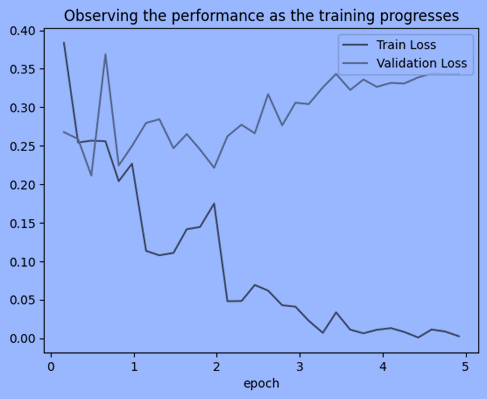

### 학습 기간에 대한 결론  

보시다시피, 평가 세트의 결과에 따르면 학습 시간을 절반으로 줄이고 두 번의 에포크 대신 **한 번의 에포크**만 사용하는 것이 더 나을 수 있습니다.  
두 에포크를 선택한 이유는 이를 직접 확인할 수 있도록 하기 위함입니다. 첫 번째 에포크 이후 모델이 학습 세트에 과적합되기 시작하여 정확도가 떨어지고 가치가 감소하는 것으로 보입니다.  
두 에포크 이상의 결과도 검토해볼 것을 권장합니다.  

### 딥러닝 훈련 결과 생성: 설계 선택에 활용

In [ ]:
results_train_train = trainer.predict(train_train_tokenized)#
predictions_train_train = np.argmax(results_train_train[0], axis=-1)

accuracy_dl_train = np.mean(predictions_train_train == train_train_df["label"])
baseline_accuracy_dl_train = np.mean(most_frequent_class == train_train_df["label"])
accuracy_dl_lift_train = 100 * (accuracy_dl_train/baseline_accuracy_dl_train - 1)

print("딥러닝 언어 모델의 훈련 세트 결과:\n-------------------------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_dl_train, 2))
print("현재 모델의 정확도:", round(accuracy_dl_train, 2))
print("정확도 향상은:", round(accuracy_dl_lift_train), "%")

### Generate the DL test results: Use for presenting performance

In [ ]:
results_test = trainer.predict(test_tokenized)
predictions_test = np.argmax(results_test[0], axis=-1)

accuracy_dl_test = np.mean(predictions_test == test_df["label"])
baseline_accuracy_dl_test = np.mean(most_frequent_class == test_df["label"])
accuracy_dl_lift = 100 * (accuracy_dl_test/baseline_accuracy_dl_test - 1)

print("딥러닝 언어 모델의 테스트 세트 결과:\n---------------------------------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_dl_test, 2))
print("현재 모델의 정확도:", round(accuracy_dl_test, 2))
print("정확도 향상은:", round(accuracy_dl_lift), "%")

print("\n혼동 행렬(Confusion Matrix):")
print(confusion_matrix(test_df["label"], predictions_test))
print("\n분류 보고서(Classification Report):")
print(classification_report(test_df["label"], predictions_test))

<a id='pytorch_native'></a>